In [83]:
import torch
import torchvision
import kornia
from torchvision.transforms import v2 as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.v2.functional import adjust_contrast, adjust_saturation, equalize, adjust_gamma, adjust_sharpness, invert, posterize, to_grayscale
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageOps
import lightning.pytorch as pl
import os

from lightning.pytorch.utilities.types import OptimizerLRScheduler
import torchmetrics
import numpy as np
from flash.image import ImageClassificationData, ImageClassifier

In [84]:
class MultiLabelDataset(Dataset):
    def __init__(self, df, transforms=None, label_list=None, normalize=None):
        self.label_list = label_list
        self.df = self.encode_dataset(df)
        self.transforms = transforms
        self.normalize = normalize

    def __getitem__(self, index):
        image, label = self.get_img(index)

        if self.transforms is not None:
            image = transforms.ToTensor()(image)
            image = image.type(torch.float32)
           
            image = self.normalize(image)

            image = transforms.ToImagePIL()(image)
            image_layers = self.transforms(image)

            for i, img in enumerate(image_layers):
                image_layers[i] = transforms.ToTensor()(img)

        image = torch.cat(image_layers, dim=0)
        
        return image, label

    def __len__(self):
        return self.df.shape[0]
    
    def get_img(self, index):
        img_path, label = self.df.iloc[index]
        return Image.open(img_path), label
    
    def show_img(self, index):

        image, label = self.get_img(index)
        transformed_image = self.transforms(image)
        
        fig, ax = plt.subplots(1, len(transformed_image)+1, figsize=(10, 10))
        ax[0].imshow(image)
        ax[0].set_title(self.decode_labels(label))

        for i, img in enumerate(transformed_image):
            ax[i+1].imshow(transforms.ToPILImage()(img))
    
    def show_images_per_deasease(self):
        df_unique = self.df.copy()
    
        # Count the number of 1 in labels
        df_unique['sum'] = df_unique['labels'].apply(lambda x: sum(x))
        df_unique = df_unique[df_unique['sum'] == 2].drop('sum', axis=1)
        df_unique['labels'] = df_unique['labels'].apply(lambda x: str(x))
        df_unique = df_unique.drop_duplicates(subset='labels')

        for idx in df_unique.index:
            self.show_img(idx)

    def encode_dataset(self, df):
        df['labels'] = df[self.label_list].apply(lambda x: (x.values == 1).astype(int), axis=1)
        return df[['file_name', 'labels']]

    def decode_labels(self, labels):
        return [self.label_list[i] for i, x in enumerate(labels) if x == 1]

In [85]:
data_dir = '../datasets/training/'
val_dir = '../datasets/evaluation/'
test_dir = '../datasets/test/'

train_df = pd.read_csv(data_dir + 'metadata.csv')
val_df = pd.read_csv(val_dir + 'metadata.csv')
test_df = pd.read_csv(test_dir + 'metadata.csv')

train_df['file_name'] = train_df['file_name'].apply(lambda x: data_dir + x)
val_df['file_name'] = val_df['file_name'].apply(lambda x: val_dir + x)
test_df['file_name'] = test_df['file_name'].apply(lambda x: test_dir + x)


Index(['Disease_Risk', 'DR', 'ARMD', 'MH', 'DN', 'MYA', 'BRVO', 'TSLN', 'LS',
       'CSR', 'ODC', 'CRVO', 'ODP', 'ODE', 'RS', 'CRS', 'RPEC'],
      dtype='object') 17


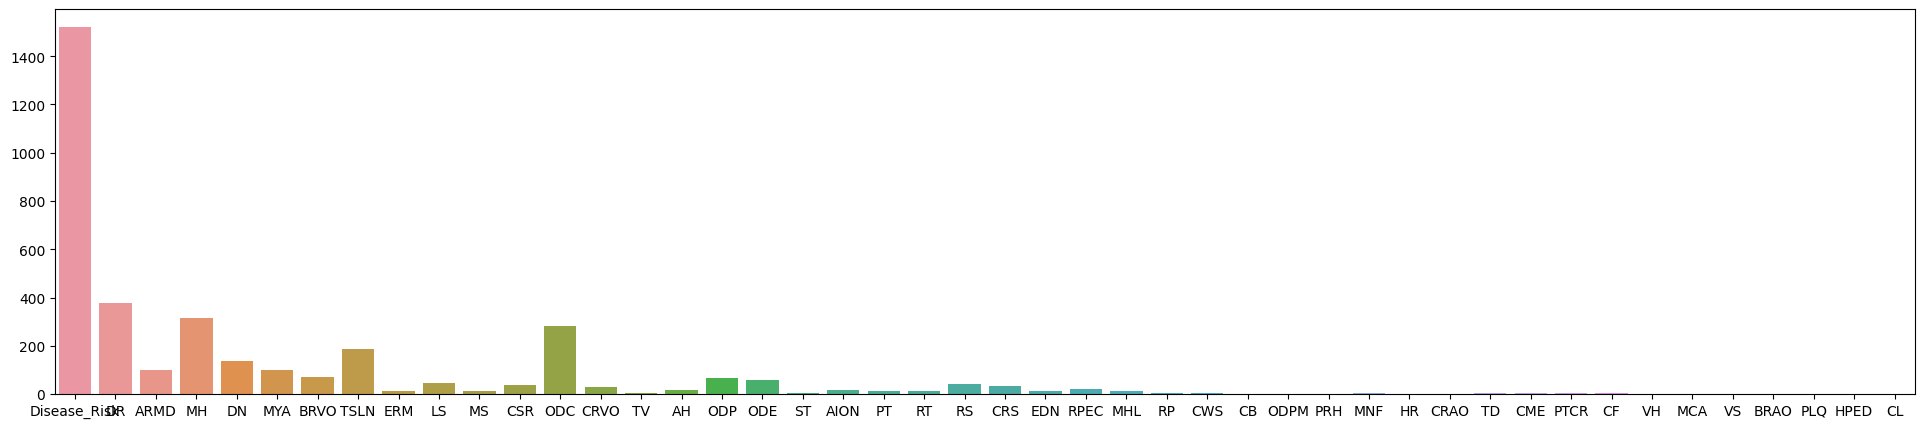

In [86]:
# Bar plot of the number of images per class
plt.figure(figsize=(24, 5))
sns.barplot(x=train_df.drop('file_name', axis=1).sum().index, y=train_df.drop('file_name', axis=1).sum().values)

# Print column names with more than x images
threshold = 20

label_list = train_df.drop('file_name', axis=1).sum()[train_df.drop('file_name', axis=1).sum() > threshold].index
print(label_list, len(label_list))


In [87]:
IMAGE_SIZE = 250
BATCH_SIZE = 32

MEAN_4288_2848 = [0.59169255, 0.28666516, 0.09397617]
STD_4288_2848 = [0.17994411, 0.12810065, 0.08768493]

MEAN_2144_1424 = [0.6072398,  0.40012667, 0.22312242]
STD_2144_1424 = [0.15314142, 0.12791779, 0.12009073]

MEAN_2048_1536 = [0.49654163, 0.25455866, 0.11922807]
STD_2048_1536 = [0.13767262, 0.09073118, 0.10520288]

MEAN = [0.59394743, 0.33779393, 0.15540815]
STD = [0.16763987, 0.13925351, 0.12256385]


def normalize_image(image):
    transform_list = [transforms.PILToTensor()]
    match image.size:
        case (4288, 2848):
            transform_list.append(transforms.Normalize(MEAN_4288_2848, STD_4288_2848))
        case (2144, 1424):
            transform_list.append(transforms.Normalize(MEAN_2144_1424, STD_2144_1424))
        case (2048, 1536):
            transform_list.append(transforms.Normalize(MEAN_2048_1536, STD_2048_1536))
        case _:
            transform_list.append(transforms.Normalize(MEAN, STD))

    return transforms.Compose(transform_list)(image)

def resize_image(image):
    if image.size == (4288, 2848):
        image = transforms.Resize(IMAGE_SIZE)(image)
        image = image.crop((50, 0, 50 + IMAGE_SIZE, IMAGE_SIZE))

    return transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.CenterCrop(IMAGE_SIZE)])(image)


def augment_image(image):
    return transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.6, 1.0), ratio=(1, 1)),
    ])(image)


def transform_image(image):
    image = resize_image(image)
    image = augment_image(image)

    image_eq = adjust_contrast(image, 1.2)
    image_eq = adjust_sharpness(image_eq, 1.5)
    image_eq = equalize(image_eq)
    image_eq = adjust_gamma(image_eq, 0.9)

    image_sharp = adjust_contrast(image, 1.5)
    image_sharp = adjust_sharpness(image_sharp, 1.5)
    image_sharp = posterize(image_sharp, 3)
    image_sharp = to_grayscale(image_sharp, num_output_channels=1)

    return [image, image_eq, image_sharp]

train_dataset = MultiLabelDataset(train_df, transforms=transform_image, label_list=label_list, normalize=normalize_image)
val_dataset = MultiLabelDataset(val_df, transforms=transform_image, label_list=label_list, normalize=normalize_image)
test_dataset = MultiLabelDataset(test_df, transforms=transform_image, label_list=label_list, normalize=normalize_image)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/transforms/v2/functional/_deprecated.py:17: UserWarning: The function `to_grayscale(...)` is deprecated in will be removed in a future release. Instead, please use `convert_color_space(..., color_space=datapoints.ColorSpace.GRAY)`.
  warnings.warn(


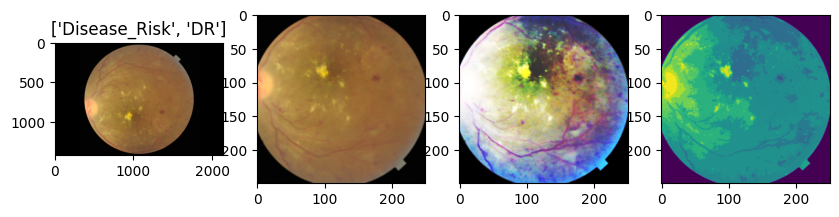

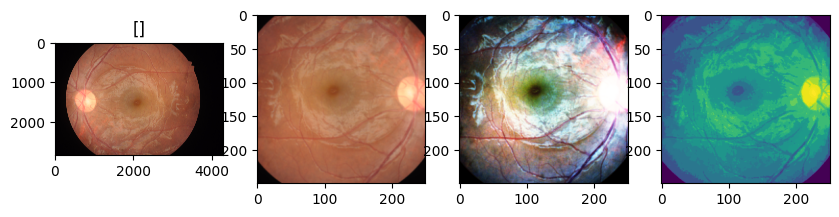

In [88]:
train_dataset.show_img(0)
train_dataset.show_img(1600)

In [89]:
print(train_dataset[0][0].shape)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


torch.Size([7, 250, 250])
torch.Size([7, 250, 250])


In [90]:
# train_dataset.show_images_per_deasease()

In [91]:
# Define the data module

class DataModule(pl.LightningDataModule):
    def __init__(self, train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE):
        super().__init__()
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset
        self.batch_size = batch_size

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=0)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0)
    



In [92]:
# Define the model

class MultiLabelImageClassifierModel(pl.LightningModule):
    def __init__(self, num_classes, input_size, num_channels):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(num_channels, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),

            torch.nn.BatchNorm2d(512),

            torch.nn.Flatten(),
            torch.nn.Linear(512 * (input_size // 32) * (input_size // 32), 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, num_classes),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        return x


In [93]:
# LightningModule

class LModule(pl.LightningModule):
    def __init__(self, model, label_list, lr=1e-3, epochs=10, data_loader=None):
        super().__init__()
        self.model = model
        self.lr = lr
        self.epochs = epochs
        self.data_loader = data_loader

        self.f1_score = torchmetrics.F1Score(top_k=1, task="multiclass", num_classes=len(label_list), average='weighted')
        self.accuracy = torchmetrics.Accuracy(top_k=1,task="multiclass", num_classes=len(label_list), average='weighted')
        self.recall = torchmetrics.Recall(top_k=1,task="multiclass", num_classes=len(label_list), average='weighted')
        self.precision = torchmetrics.Precision(top_k=1,task="multiclass", num_classes=len(label_list), average='weighted')

        self.criterion = torch.nn.BCELoss()

    def forward(self, x, *args, **kwargs):
        return self.model(x)
    
    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
#         self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=CFG.t_max, eta_min=CFG.min_lr)
        self.scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, 
                                                                max_lr=self.lr, 
                                                                epochs=self.epochs,
                                                                steps_per_epoch=len(self.data_loader))
                                                                
        scheduler = {'scheduler': self.scheduler, 'interval': 'step',}

        return [self.optimizer], [scheduler]
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        y = y.to(torch.float32)
        y_hat = y_hat.to(torch.float32)
        loss = self.criterion(y_hat, y)

        f1_score = self.f1_score(y_hat, y)
        accuracy = self.accuracy(y_hat, y)
        recall = self.recall(y_hat, y)


        logs = {'train_loss': loss, 'lr': self.optimizers().param_groups[0]['lr'], 'train_f1': f1_score, 'train_accuracy': accuracy, 'train_recall': recall}

        self.log_dict(
            logs,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True
        )
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        y = y.to(torch.float32)
        y_hat = y_hat.to(torch.float32)
        loss = self.criterion(y_hat, y)

        f1_score = self.f1_score(y_hat, y)
        accuracy = self.accuracy(y_hat, y)
        recall = self.recall(y_hat, y)

        logs = {'val_loss': loss, 'val_f1': f1_score, 'val_accuracy': accuracy, 'val_recall': recall}

        self.log_dict(
            logs,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True
        )
        
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        y = y.to(torch.float32)
        y_hat = y_hat.to(torch.float32)
        loss = self.criterion(y_hat, y)

        f1_score = self.f1_score(y_hat, y)
        accuracy = self.accuracy(y_hat, y)
        recall = self.recall(y_hat, y)

        logs = {'test_loss': loss, 'test_f1': f1_score, 'test_accuracy': accuracy, 'test_recall': recall}

        self.log_dict(
            logs,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True
        )
        
        return loss

In [94]:

data_loader = DataModule(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE)

model = MultiLabelImageClassifierModel(num_classes=len(label_list), input_size=IMAGE_SIZE, num_channels=7)

lmodule = LModule(model, label_list, lr=1e-3, epochs=10, data_loader=data_loader.train_dataloader())

In [95]:
# Train the model

trainer = pl.Trainer(max_epochs=10)
trainer.fit(lmodule, data_loader.train_dataloader(), data_loader.val_dataloader())



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/theo/Documents/Algo/DataCamp/models/lightning_logs

  | Name      | Type                           | Params
-------------------------------------------------------------
0 | model     | MultiLabelImageClassifierModel | 28.3 M
1 | f1_score  | MulticlassF1Score              | 0     
2 | accuracy  | MulticlassAccuracy             | 0     
3 | recall    | MulticlassRecall               | 0     
4 | precision | MulticlassPrecision            | 0     
5 | criterion | BCELoss                        | 0     
-------------------------------------------------------------
28.3 M    Trainable params
0         Non-trainable params
28.3 M    Total params
113.316   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])
torch.Size([7, 250, 250])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
# Save model

torch.save(model.state_dict(), './nul')



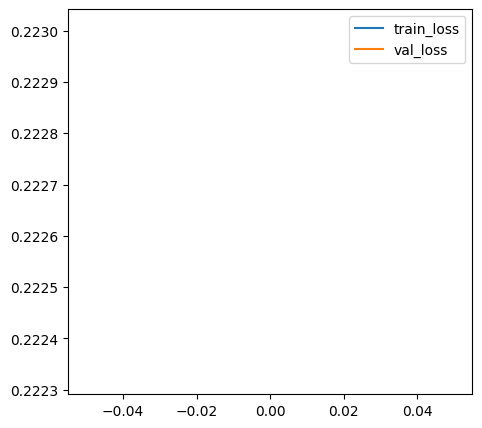

In [ ]:
# Plot evolution of the metrics
# TODO: Get the metrics from the trainer

plt.figure(figsize=(24, 5))
plt.subplot(1, 4, 1)
plt.plot(trainer.callback_metrics['train_loss'])
plt.plot(trainer.callback_metrics['val_loss'])
plt.title('Loss')
plt.legend(['train', 'val'])
plt.subplot(1, 4, 2)
plt.plot(trainer.callback_metrics['train_f1'])
plt.plot(trainer.callback_metrics['val_f1'])
plt.title('F1')
plt.legend(['train', 'val'])
plt.subplot(1, 4, 3)
plt.plot(trainer.callback_metrics['train_accuracy'])
plt.plot(trainer.callback_metrics['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'val'])
plt.subplot(1, 4, 4)
plt.plot(trainer.callback_metrics['train_recall'])
plt.plot(trainer.callback_metrics['val_recall'])
plt.title('Recall')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
model = MultiLabelImageClassifierModel(num_classes=len(label_list), input_size=IMAGE_SIZE, num_channels=5)
model.load_state_dict(torch.load('./nul.pth'))

<All keys matched successfully>

In [ ]:
# Plot one image with the labels and the predictions

model.eval()

idx = 1
image, label = test_dataset[idx]

image = image.unsqueeze(0)
pred = model(image)


In [ ]:
print(pred)
print(label)

tensor([[0.7910, 0.1800, 0.0388, 0.1406, 0.0614, 0.0358, 0.0295, 0.0749, 0.0173,
         0.0139, 0.1242, 0.0103, 0.0239, 0.0242, 0.0162, 0.0115, 0.0082]],
       grad_fn=<SigmoidBackward0>)
[1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
